# Lab 4: Mixture Models, K-means and Expectation-Maximisation (EM)

In this lab we will focus on the modelling of data generated through a number of distinct distributions (mixture models) and how to extract information from data generated in this way through unsupervised clustering algorithms (k-means, expectation-maximisation).

First, we will import the required packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from scipy.stats import multivariate_normal    

import imageio.v3 as iio

## 1) Mixture Models
In machine learning it is very common to construct a model of the observed data explicitly through the use of a distribution (e.g. Gaussian, Bernoulli, Categorical etc.). Provided the choice of the distribution type is reasonable, the observed data can often be used to estimate the parameters of the distribution (e.g. mean, variance etc.) that fit the data well. However, in many cases the data distribution is more complex and could potentially be *multimodal* which cannot be captured well with a unimodal distribution. Mixture models provide a conceptually simple solution to this problem by combining multiple distributions to form more complex ones.

**What are mixture models?**
A mixture model is a probabilistic model used to represent variables that have a distribution derived from the combination of a number of different distributions, each corresponding to some subpopulation of the overall population. It is worth noting that within a mixture model it is not required for any observed data point to identify which subpopulation it belongs to.

Formally, each data point $x_i$ can be assumed to come from $1$ of $K$ distributions (subpopulations). A latent (hidden) variable $z_i$ is used to determine which of the subpopulation distributions is used and this is modelled by a categorical distribution with $K$ categories, $z_i \sim Categorical(\phi)$, where $\phi$ is a vector of $K$ elements containing the probabilities of each category. Note that $$\sum_{j=1}^K{\phi_j} = 1$$

For simplicity, in this example we will assume that each subpopulation distribution is Gaussian which makes this an example of a Gaussian Mixture Model (GMM). The parameters of each distribution are their mean $\mu_j$ and covariance matrix $\Sigma_j$.


### 1.1) Sampling from a Gaussian mixture model

In this section we will go through the key steps involved in sampling from a Gaussian Mixture Model and use this code to generate some example data for us to work with. The code below defines the means and covariance matrices for three Gaussian distributions:

$$\mu_1 = \begin{bmatrix} 0\\ 0\end{bmatrix}, 
\Sigma_1 = \begin{bmatrix} 0.7 & -0.4\\ -0.4 & 0.5\end{bmatrix},\:
\mu_2 = \begin{bmatrix} 5\\ 2\end{bmatrix},\:
\Sigma_2 = \begin{bmatrix} 1.0 & 0.6\\ 0.6 & 1.0\end{bmatrix},\:
\mu_3 = \begin{bmatrix} 1\\ 7\end{bmatrix},\:
\Sigma_3 = \begin{bmatrix} 0.5 & 0.0\\ 0.0 & 0.5\end{bmatrix}$$

in addition to the parameters to the categorical distribution:

$$\phi = \begin{bmatrix} 1/3 \\ 1/3 \\ 1/3\end{bmatrix}$$

In [2]:
N = 250 # number of data points / samples

# GMM parameters
K = 3 # number of categories
category_prob = np.array([1/3.0, 1/3.0, 1/3.0]) # (phi) probability of each category (must sum to 1)

# Mean of each Gaussian
means = np.array([[0.0, 0.0], # mean_1
                  [5.0, 2.0], # mean_2
                  [1.0, 7.0]]) # mean_3

# Covariance martix of each Gaussian
covariance_matrices = np.array([[[0.7, -0.4], # cov_1
                                 [-0.4, 0.5]], 
                                [[1.0, 0.6], # cov_2
                                 [0.6, 1.0]], 
                                [[0.5, 0.0], # cov_3
                                 [0.0, 0.5]]]) 

Sampling from the mixture model can be achieved by first sampling from the categorical distribution and then sampling from the corresponding Gaussian distribution. Note that this is another example of ancestral sampling seen in the previous lab.

Use the parameters provided to generate `N` two-dimensional samples from the GMM and store it in a matrix `X` with shape `(N, 2)`. Hint: use either [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) or [np.random.multinomial](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multinomial.html) (with n=1) to choose the categorical indicies and then sample using
the [multivariate_normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) function.

In [3]:
# write your code here

category_indices = np.random.choice(K, size=N, p=category_prob)

X = np.zeros((N, 2))
colours = np.zeros(N)

for i in range(N):
    index = category_indices[i]

    mean = means[index]
    covariance_matrix = covariance_matrices[index]
    X[i] = np.random.multivariate_normal(mean, covariance_matrix)
    colours[i] = index


Create a 2-D scatter plot of your samples in the cell below.

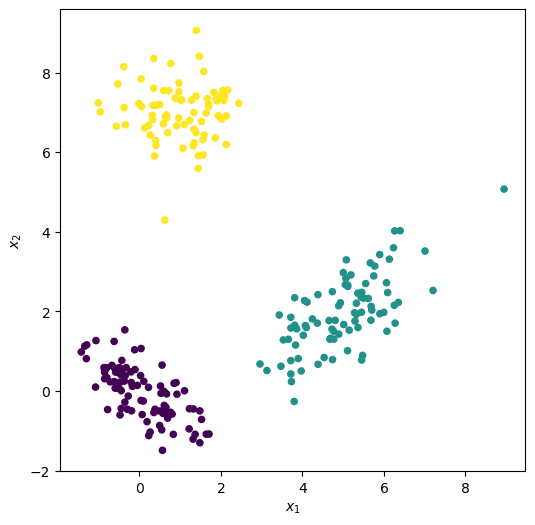

In [4]:
# write your code here
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=20, c=colours)
#plt.scatter(X[:, 0], X[:, 1], s=20, c=category_indices)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

### Exercises: 
 1. Change the values in `category_prob` vector (remember the values must sum to 1). What happens to the proportion of samples from each subpopulations?
 2. Keep track of the latent variable $z_i$ for each data point and colour them differently in the scatter plot (hint: the [scatter function](https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.scatter.html?highlight=scatter#matplotlib.pyplot.scatter) parameter `c` is used to colour the points and takes a vector of `N` integers)

## 2) K-means Clustering

K-means is a very simple and commonly used example of a clustering algorithm. Clustering is an unsupervised machine learning task in which the goal is to partition points within a dataset into distinct groups (or clusters) such that elements within the same group are similar to each other. K-means is an example of a hard-clustering method which means that each point can only be assigned to a single cluster and there are hard boundaries between clusters.

**How does K-means work?** The K-means algorithm involves an iterative procedure of multiple steps which can be summarised as follows:
 1. Choose a value for the number of clusters, $K$. This $K$ is an input to the algorithm and is fixed throughout. There is no correct way for this value to be chosen and it is typically done by either using some domain knowledge of the dataset, through trial and error or through other some other methods (e.g. Elbow Method, Silhouette Method). 
 2. Randomly initialise $K$ cluster centroids. These centroids are points in the data space that represent the mean of a cluster. Typically each of these centroids are initialised at the location of a randomly selected data point.
 3. For each data point, compute the Euclidean distance to each cluster centroid. Assign the data point to the cluster corresponding to the closest centroid.
 4. For each cluster, update the cluster centroid to be the mean of all of the data points assigned to that cluster.
 5. Repeat steps **3** and **4** until the cluster assignments do not change.
 
For more information on K-means clustering, see Bishop section 9.1.


### 2.1 Implementing K-means

In this section your task is to implement the key steps of the K-means algorithm. Specifically:
1. Implement a `get_cluster_assignments` function that performs step 3 of the above algorithm. This function should return a  vector (`shape = (N,)`) containing the assigned cluster indices corresponding to each data point and should take the parameters:
 - `X` - Your data points (`shape = (N, 2)`)
 - `centroid_locations` - The location of each cluster centroid (`shape = (K, 2)`)
 
Hint, use [np.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) to find the Euclidean distances.
    
2. Implement a `get_cluster_centroids` function that performs step 4 of the above algorithm. This function should return a `(K, 2)` matrix containing the `K` cluster centroid locations and take the parameters:
 - `X` - Your data points (`shape = (N, 2)`)
 - `cluster_assignments` - The current cluster assignments for each data point (`shape = (N,)`).
 

In [5]:
# write your code here
def get_cluster_assignments(X, centroid_locations):
    assignments = []
    for x in X:
        centroid_distances = np.linalg.norm(x - centroid_locations, axis=1)
        centroid_index = np.argmin(centroid_distances)
        assignments.append(centroid_index)
    return np.array(assignments)
def get_cluster_centroids(X, cluster_assignments):
    centroids = []
    for i in range(K):
        cluster_data_points = X[cluster_assignments == i]
        centroid = np.mean(cluster_data_points, axis=0)
        centroids.append(centroid)
    return np.array(centroids)

The cell below sets the value of `K` (step 1) and performs the initialisation (step 2) of the cluster centroids by selecting `K` data points at random. It then runs the remaining steps of the K-means algorithm with the functions you implemented. Make sure to read through this code to understand what it's doing and use it to test your implementation.

Initial centroids:  [[-0.37652591  7.12182723]
 [-0.59488768  0.07198607]
 [-0.35802654 -0.27941777]]
Initial Clustering:


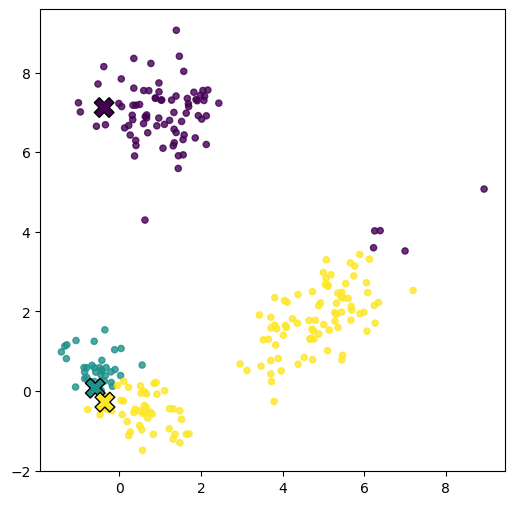

Iteration 1:


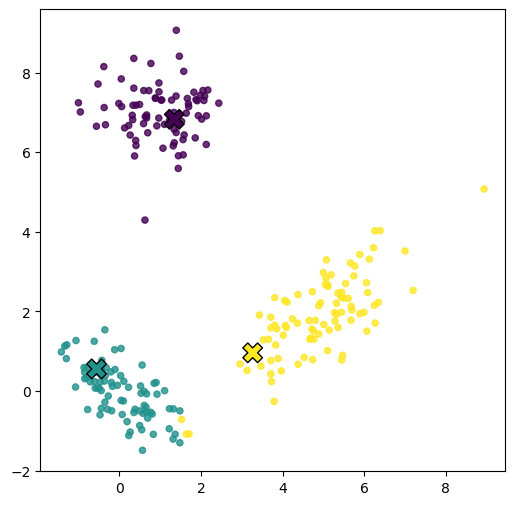

Iteration 2:


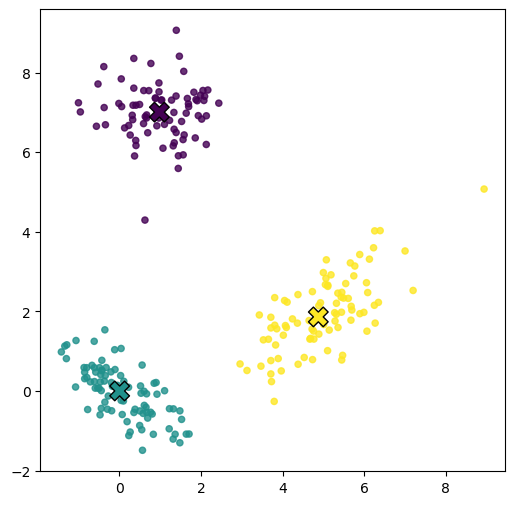

Iteration 3:


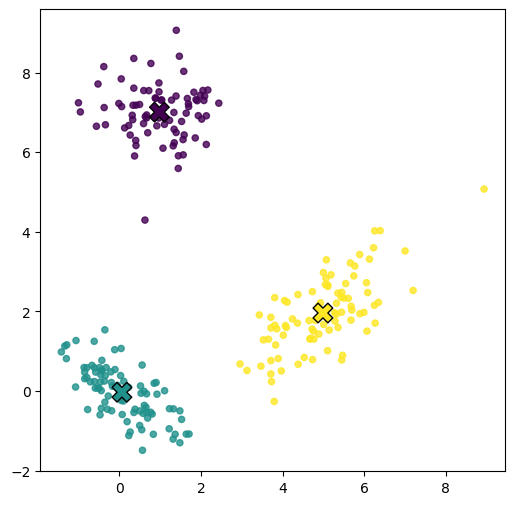

Stopped! Cluster assignments did not change. 


In [6]:
def plot_k_means(X, cluster_assignments, centroid_locations):
    plt.figure(figsize=(6, 6))
    plt.viridis() # Set colour map
    plt.scatter(X[:, 0], X[:, 1], s=20, c=cluster_assignments, alpha=0.8) # plot data points
    plt.scatter(centroid_locations[:, 0], centroid_locations[:, 1], s=200, marker='X', c=range(K), edgecolors='k') # plot centroids
    plt.show()
    
K = 3
# Initialise cluster centroids by chosing K distinct random data points
centroid_locations = X[np.random.choice(X.shape[0], K, replace=False)]
print("Initial centroids: ", centroid_locations)

# Assign each data point to its nearest cluster
cluster_assignments = get_cluster_assignments(X, centroid_locations)

print('Initial Clustering:')
plot_k_means(X, cluster_assignments, centroid_locations)      

# Run K-means
max_iterations = 30
for iteration in range(1, max_iterations+1):
    centroid_locations = get_cluster_centroids(X, cluster_assignments)
    
    prev_cluster_assignments = cluster_assignments
    cluster_assignments = get_cluster_assignments(X, centroid_locations)
    
    print(f"Iteration {iteration}:")
    plot_k_means(X, cluster_assignments, centroid_locations)    
    
    if np.all(cluster_assignments == prev_cluster_assignments):
        print("Stopped! Cluster assignments did not change. ")
        break

### Exercises:
- Run the algorithm 10 or more times. Are the resulting clusters always the same?
- Experiment with changing the means, covariance matrices or both parameters when generating the original data. What happens to the consistency of the clustering if you make the cluster distributions overlap more?

### 2.2) K-means in scikit-learn

Thankfully we do not need to implement K-means from scratch each time and can use scikit-learn's [`KMeans` implementation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).

Read through the documentation and run this implementation on the same data. Plot the final result using the `plot_k_means` function (hint: the centroid locations can be accessed through the `cluster_centers_` attribute).

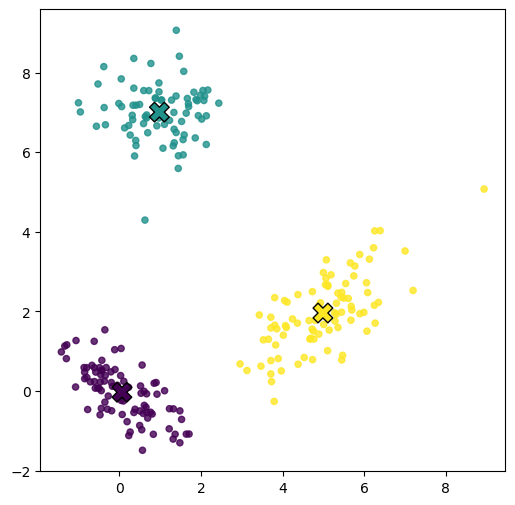

In [7]:
# write your code here
km = KMeans(K)

km.fit_predict(X)

plot_k_means(X, km.labels_, km.cluster_centers_)

### 2.3) Finding a good K value

As mentioned before, choosing a good K value for your data may not be straightforward. However, for any given clustering it is possible to assign a score based on the sum of squared distances between the data points and their cluster's centroid across the entire dataset. This score gives a measure of how similar data points are to their centroids. The goal is to find the smallest value for K that also gives a reasonably small sum of squared distances.

Use scikit-learn to run K-means with values of `K` between 1 and 10. Create a plot showing the relationship between the `K` value and the score (hint: this score can be computed using the [`score`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.score) function).

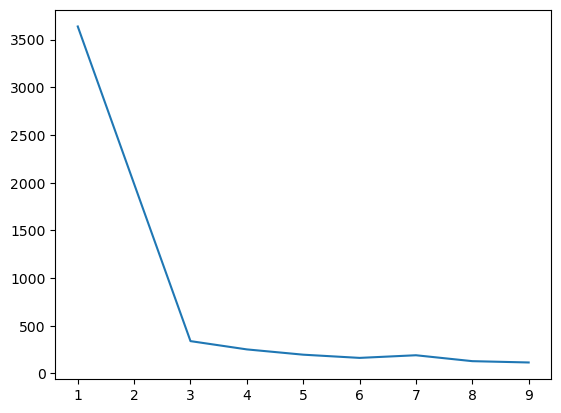

In [8]:
# write your code here
K_values = range(1, 10)
scores = []
for i in K_values:
    km = KMeans(i).fit(X)

    scores.append(-km.score(X))

plt.figure()
plt.plot(K_values, scores)
plt.show()

The Elbow Method refers to visually choosing K at the point where there are diminishing returns for increasing K (i.e. the elbow if you think of the plot as an arm). What value for K would you chose for this data?

## 3) Expectation-Maximisation algorithm

One way to think about Expectation-Maximisation (EM) is similar to clustering methods like K-means. 

However, there are some key differences:
- As we saw with K-means it is a hard-clustering method that assigns each point to only one cluster. Expectation Maximisation can instead be used to perform soft-clustering in which a belief is modelled about each point's cluster assignment in the form of a distribution.
- K-means assigns points to clusters based on the Euclidean distance to the means (centroids) of those clusters. In our case we know that our data is generated from a Gaussian Mixture Model so any given point must come from one of K Gaussian distributions. Using the Euclidean distance to the mean fails to completely capture the likelihood of a point being generated from a given Gaussian because it is possible for points further away to be more likely than points that are closer if there is a larger variance in that direction.


Using a Gaussian Mixture Model, we would like to be able to estimate the model parameters, $\theta = \{\mu_{1..K}, \Sigma_{1..K}, \phi_{1..K}\}$ that maximise the likelihood of seeing the data contained in the dataset, $P(X \vert \theta)$. These parameter estimates can be used to obtain a distribution over the latent cluster assignments, $P(z_i)$, for each data point $i$. This set of probabilities (distribution) over the clusters for a given data point is typically referred to as its *responsibilities* (i.e. how responsible is each cluster for generating this data point). The key problem that EM addresses is that estimating the model parameters directly from the data without knowledge of the cluster assignments is computationally intractable.

Intuitively, the problem of finding both the model parameters and cluster responsibilities can be viewed as a chicken and egg problem. If the parameters for each Gaussian and the mixing probabilities ($\phi$) are known then it is easy to compute the likelihood for each data point and build a belief about which cluster it belongs to. Similarly, if the cluster responsibilities are known then it is easy to fit the parameters of each Gaussian. This can be achieved for each cluster by fitting a Gaussian to the entire data set where each point has been weighted by the cluster's responsibility for that point.

**How does the EM algorithm work?** Instead of solving the problem all at once, the EM algorithm uses an iterative approach that alternates between two steps: an Expectation step and a Maximisation step. 

The steps can be summarised as follows:
1. Initialise all model parameters, $\theta$. This can initialised completely randomly or by running k-means first to get a starting point.
2. **Expectation Step:** Using the current $\theta$, compute the responsibilities, $P(z_i)$, for each data point, $i$.
3. **Maximisation Step:** Using the responsibilities, $P(z_i)$, estimate the model parameters $\theta$.
4. Repeat steps **2** and **3** until the model parameters and cluster responsibilities converge (i.e. stop when the change between consecutive iterations is below some threshold).

For more information on EM, see Bishop section 9.2 - 9.4.

### 3.1 Performing EM on our example data

Before we look at an implementation of EM, the code below first defines some useful plotting functions. The `plot_GMM_density` plots the density of the Gaussian mixture using the estimated parameters and the `plot_GMM_mixture_components` function plots each of mixture components' densities separately.

In [9]:
def plot_GMM_density(X, gmm):
    plt.figure(figsize=(6,6))
    plt.scatter(X[:, 0], X[:, 1], s=20, c='b', alpha=0.8)
    x = np.linspace(-5., 8., 1000)
    y = np.linspace(-2., 10., 1000)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -gmm.score_samples(XX).reshape(X.shape)
    plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, np.max(np.log(Z)), 20))
    plt.show()
    
def plot_GMM_mixture_components(X, gmm):
    plt.figure(figsize=(6,6))
    plt.scatter(X[:, 0], X[:, 1], s=20, c='b', alpha=0.8)
    x = np.linspace(-5., 8., 1000)
    y = np.linspace(-2., 10., 1000)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    
    colours = ['red', 'green', 'purple']
    
    for i in range(K):
        mean, covariance = gmm.means_[i], gmm.covariances_[i]
        gaussian = multivariate_normal(mean, covariance)
        Z = -gaussian.logpdf(XX).reshape(X.shape)
        plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 1, 4), colors=colours[i])
    plt.show()

The code in the cell below performs the EM algorithm for our data using the `fit` function within scikit-learn's [`GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) implementation. Run the code and compare estimated parameters at each iteration with their known values. Note that when creating the `GaussianMixture` object we set `max_iter=10` so that each iteration of the `while True` loop below does 10 iterations of the EM algorithm each time the `fit` method is called. We also set `warm_start` to `True` so that each call to `fit` (apart from the first) starts from the values produced from the previous call to `fit`. If you want to see the individual EM iterations alter what's below to have `max_iter=1` (but that will produce a lot of plots!).

Uncomment the different plotting functions and observe how the parameter estimates change after each iteration.


Iteration 1:
Estimated means: [[0.68986497 5.29874496]
 [3.08876553 1.12800693]
 [2.57178553 1.04067072]]
Estimated covariances: [[[0.82872018 1.38635758]
  [1.38635758 9.24818699]]

 [[6.34472871 2.66131297]
  [2.66131297 1.63081145]]

 [[6.98013819 2.59636853]
  [2.59636853 2.38114114]]]


/usr/lib64/python3.14/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


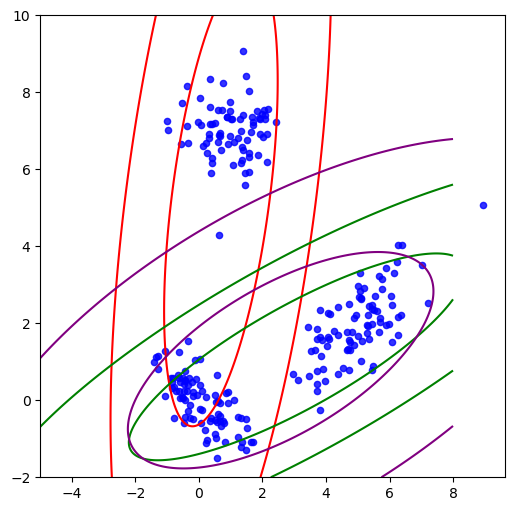

/usr/lib64/python3.14/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(



Iteration 2:
Estimated means: [[ 0.97901391  7.00721685]
 [ 4.43057078  1.58044236]
 [-0.11820858  0.10639339]]
Estimated covariances: [[[ 0.6286001  -0.00703404]
  [-0.00703404  0.48927361]]

 [[ 2.85856298  1.86908526]
  [ 1.86908526  1.65881095]]

 [[ 0.44846273 -0.26579459]
  [-0.26579459  0.37670159]]]


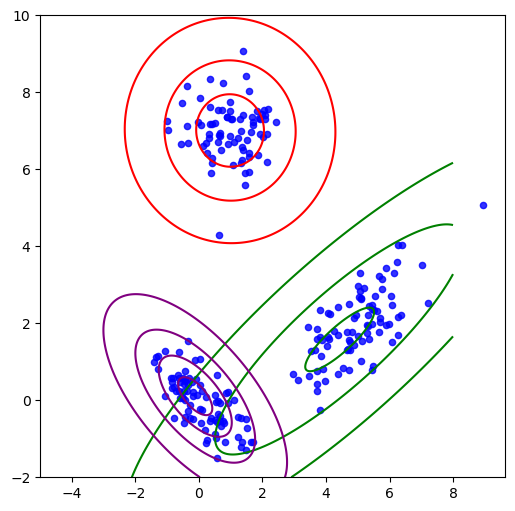


Iteration 3:
Estimated means: [[ 0.97901391  7.00721685]
 [ 4.98971266  1.95816769]
 [ 0.05884452 -0.03078011]]
Estimated covariances: [[[ 0.6286001  -0.00703404]
  [-0.00703404  0.48927361]]

 [[ 1.03760018  0.6655804 ]
  [ 0.6655804   0.87171739]]

 [[ 0.58492468 -0.35620923]
  [-0.35620923  0.44834146]]]


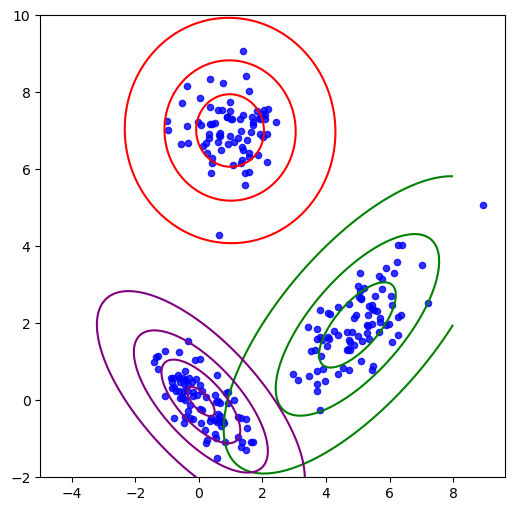

Converged!


In [10]:
K = 3
gmm = GaussianMixture(n_components=K, max_iter=10, warm_start=True, init_params='random', tol=1e-8)

iteration = 0
while True:
    iteration += 1
    print(f'\nIteration {iteration}:')
    gmm.fit(X)
    print(f'Estimated means: {gmm.means_}')
    print(f'Estimated covariances: {gmm.covariances_}')
    #plot_GMM_density(X, gmm)
    plot_GMM_mixture_components(X, gmm)
    plt.show()
    if gmm.converged_:
        print("Converged!")
        break

### 3.2 Using the model to generate new data

We now have estimates for the parameters of our data distribution that we can use for a number of purposes. Example use cases include generating new samples or filling in missing data. Remember that in practice we will almost never have access to the underlying distribution of our data. These are some of the many advantages of EM over something like K-means.

Use the [`sample`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.sample) function to generate 10,000 new samples and create a scatter plot of the result: 

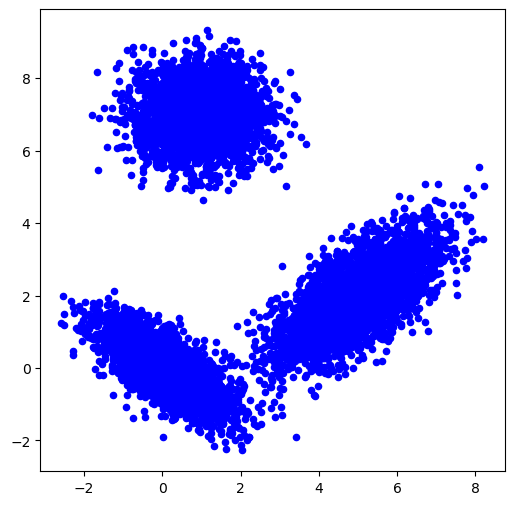

In [11]:
# write your code here
X_samples, _ = gmm.sample(10_000)

plt.figure(figsize=(6, 6))
plt.scatter(X_samples[:, 0], X_samples[:, 1], s=20, c='b')
plt.show()

## 4) Extension Exercise: Colour Quantisation

In the previous sections we have seen how to apply the K-means and EM algorithms to some simple toy data. In this section we will look how these techniques can be applied to real data to perform Vector Quantisation (Colour Quantisation). In computer vision application, colour quantisation is the task of reducing the colour pallette of an image to a fixed number of colours.

The code below loads in an example image for use in this exercise but feel free to use your own image.


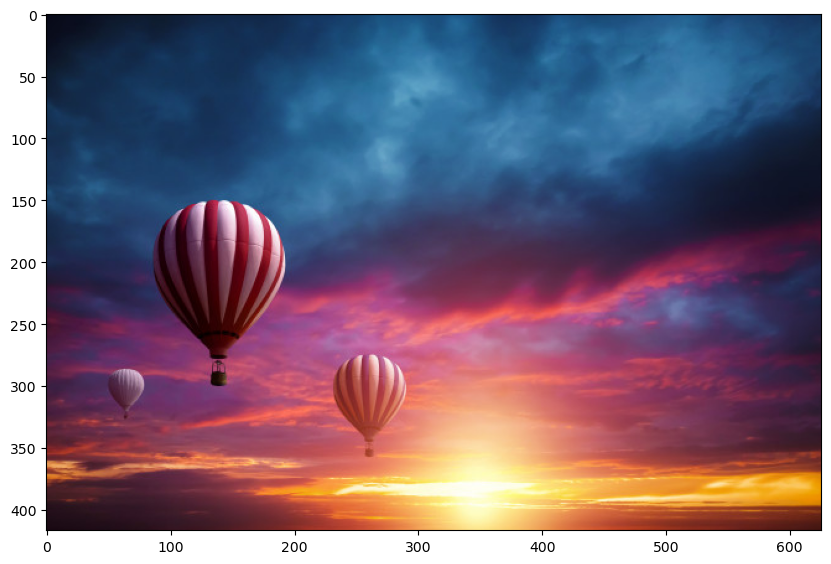

In [12]:
my_image = "sunset.jpg"

file_name = "images/" + my_image
image = np.array(iio.imread(file_name))

plt.figure(figsize=(10,10))
plt.imshow(image)

Using scikit-learn's K-means and EM implementations, apply both algorithms with $K=20$ to the image data such that each pixel location is treated as an individual 3-dimensional data point containing the $(r, g, b)$ values. Perform colour quantisation on the image by replacing the original colour values at each pixel location with the colour respresented by its corresponding cluster centroid (k-means) or distribution mean (EM). Finally, display the quantised images obtained from each method using `plt.imshow`. 

To display the quantised image correctly you may need to cast the `numpy` array to an array of type `np.uint8`. This can be achieved for a given matrix, `image_data`, by using `image_data.astype(np.uint8)`.

/usr/lib64/python3.14/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


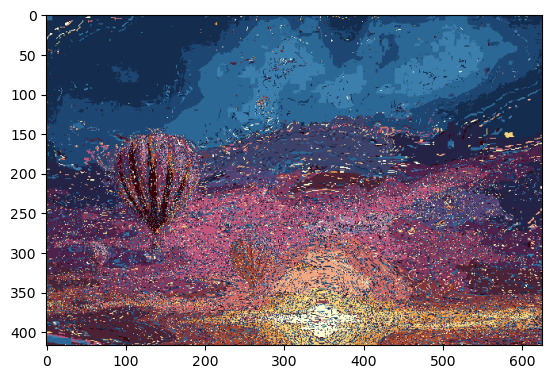

In [34]:
# write your code here
dimensions = image.shape

reshaped = image.reshape(-1, 3)
image_cast = reshaped.astype(np.uint8)

gmm = GaussianMixture(n_components=20, tol=1e-5)

gmm.fit(image_cast)

classified = gmm.predict(image_cast)
colours = gmm.means_

banded_colours = []

gmm_quantised_image = colours[classified].reshape(orig_shape).astype(np.uint8)


plt.imshow(gmm_quantised_image)

In [ ]:
print(image.shape)
print(image_cast.shape)



## Wrap up
This lab covered a number of topics so let's recap:
- We first looked at mixture models and showed how they can be used to combine simple distributions into more complex ones. For the case of a Gaussian Mixture Model (GMM), we saw how to generate samples from the distribution using the idea of ancestral sampling. 
- Next, we implemented the key steps of K-means algorithm and saw how this technique can be used to find clusters of data points within a dataset that are separated with hard boundaries. 
- We then looked at a different approach to clustering through the use of the Expectation Maximisation (EM) algorithm. We saw how this approach differs from K-means by modelling the individual cluster distributions to perform soft clustering.
- Finally, we worked through an example use case of these methods by applying them to an image's pixel data to perform Colour Quantisation.


### References
- COMS30035 Machine Learning lecture notes.
- Bishop Pattern Recognition and Machine Learning: Chapter 9.1 for the K-means algorithm and chapters 9.2-9.4 for Gaussian Mixture Models and Expectation Maximisation.